## 1. Expected Goal Model using logistic regression

$\large{\textbf{Keywords:}}$  
$\textbf{xG: }$ Expected Goals 

### 1.2 Mô hình Logistic Regression
Hai mô hình tuyến tính (Linear Model) **Linear Regression** và (PLA) **Perceptron Learning Algorithm** đều có chung một dạng:

$y = f\left(w^{T} x\right)$

Trong đó hàm $f()$ được gọi là **Activate Function** và $x$ được hiểu là dữ liệu mở rộng với $x_0 = 1$ được thêm vào để thuận tiện cho việc tính toán.
 




In [1]:
import sys
import os
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import math

project_root = os.path.abspath("..")

if project_root not in sys.path:
    sys.path.append(project_root)
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as sk_metrics
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns
import matplotlib.pyplot as plt

from preprocessing.event_data import run_pipeline
from supportFolder.plot_pitch import create_soccer_Pitch
from supportFolder.ml_help import MachineLearningHelp
from supportFolder.metrics_eval import compute_classification_metrics, plot_mertrics_comparison
import time

#các mô hình máy học
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC


Dòng bên dưới này dùng gọi hàm module event_data.py và chạy hai script sql truy vấn dữ liệu event và dữ liệu tagName truy xuất và lấy thông tin toàn bộ sự kiện sau đó tiền xử lý để có được dataframe df_events bên dưới. Module dùng để truy vấn script event_data được tự sao lưu thành 3 file dữ liệu gồm 2 file event_data.parquet và tagName.parquet là file raw chưa được tiền xử lý cùng với một file event_data_transforms.parquet là file đã được tiền xử lý như tạo thêm các thuộc tính và ánh xạ với tagName để lấy sự kiện ghi bàn hoặc các sự kiện liên quan

In [2]:
#df_events = run_pipeline(save=True)

In [3]:
path_parquet = "/home/datgegt/projects/tf216/football-data-visualization-and-analysis-dashboard/dataset/data_transforms/event_data_transform.parquet"
df_events = pd.read_parquet(path_parquet, engine='pyarrow')

In [4]:
df_events.head(10)

,ID,matchID,matchPeriod,eventSec,eventName,subEventName,teamID,posBeforeXMeters,posBeforeYMeters,posAfterXMeters,posAfterYMeters,playerID,playerName,playerPosition,playerStrongFoot,teamPossession,homeTeamID,awayTeamID,Goal,Own goal,Counter attack,bodyPartShot,bodyPartShotCode
0,700820,1694390,2H,0.814000,Pass,Simple pass,11944,52.50,32.64,51.45,32.64,83753,N. Stanciu,Midfielder,right,11944.0,4418,11944,0,0,0,Unknown,0
1,700821,1694390,2H,0.814000,Pass,Simple pass,11944,51.45,32.64,40.95,34.00,6165,F. Andone,Forward,right,11944.0,4418,11944,0,0,0,Unknown,0
2,700001,1694390,1H,1.255990,Pass,Simple pass,4418,52.50,32.64,49.35,34.00,26010,O. Giroud,Forward,left,4418.0,4418,11944,0,0,0,Unknown,0
3,700002,1694390,1H,2.351908,Pass,Simple pass,4418,49.35,34.00,43.05,32.64,3682,A. Griezmann,Forward,left,4418.0,4418,11944,0,0,0,Unknown,0
4,700822,1694390,2H,2.677000,Pass,High pass,11944,40.95,34.00,72.45,9.52,83824,M. Pintilii,Midfielder,right,11944.0,4418,11944,0,0,0,Unknown,0
5,700003,1694390,1H,3.241028,Pass,Simple pass,4418,43.05,32.64,33.60,23.80,31528,N. Kanté,Midfielder,right,4418.0,4418,11944,0,0,0,Unknown,0
6,700823,1694390,2H,5.545170,Pass,Head pass,4418,32.55,58.48,74.55,63.92,7858,B. Sagna,Defender,right,4418.0,4418,11944,0,0,0,Unknown,0
7,700004,1694390,1H,6.033681,Pass,High pass,4418,33.60,23.80,93.45,4.08,7855,L. Koscielny,Defender,right,4418.0,4418,11944,0,0,0,Unknown,0
8,700824,1694390,2H,10.532000,Pass,Launch,11944,30.45,4.08,58.80,4.08,105330,R. Raț,Defender,left,11944.0,4418,11944,0,0,0,Unknown,0
9,700005,1694390,1H,13.143591,Duel,Ground defending duel,4418,93.45,4.08,89.25,0.00,25437,B. Matuidi,Midfielder,left,4418.0,4418,11944,0,0,0,Unknown,0


In [5]:
df_shots = df_events[df_events['eventName'] == 'Shot'].copy()

In [6]:
df_shots[['posBeforeXMeters', 'posBeforeYMeters']].describe()

,posBeforeXMeters,posBeforeYMeters
count,43068.000000,43068.000000
mean,89.079096,33.481963
std,8.222725,9.366742
min,52.500000,0.000000
25%,81.900000,26.520000
50%,91.350000,33.320000
75%,95.550000,40.800000
max,105.000000,68.000000


In [7]:
df_shots

,ID,matchID,matchPeriod,eventSec,eventName,subEventName,teamID,posBeforeXMeters,posBeforeYMeters,posAfterXMeters,posAfterYMeters,playerID,playerName,playerPosition,playerStrongFoot,teamPossession,homeTeamID,awayTeamID,Goal,Own goal,Counter attack,bodyPartShot,bodyPartShotCode
24,700009,1694390,1H,31.226217,Shot,Shot,4418,95.55,19.72,0.0,0.0,25437,B. Matuidi,Midfielder,left,4418.0,4418,11944,0,0,0,rightFoot,3
61,700851,1694390,2H,100.604872,Shot,Shot,11944,79.80,18.36,105.0,68.0,83753,N. Stanciu,Midfielder,right,11944.0,4418,11944,0,0,0,rightFoot,3
85,700865,1694390,2H,130.592908,Shot,Shot,11944,93.45,27.20,105.0,68.0,33235,B. Stancu,Forward,right,11944.0,4418,11944,0,0,0,rightFoot,3
89,700044,1694390,1H,143.119551,Shot,Shot,11944,74.55,19.72,105.0,68.0,83824,M. Pintilii,Midfielder,right,11944.0,4418,11944,0,0,0,rightFoot,3
137,700060,1694390,1H,219.576026,Shot,Shot,11944,100.80,38.76,105.0,68.0,33235,B. Stancu,Forward,right,11944.0,4418,11944,0,0,0,rightFoot,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3024471,2746238,2576338,1H,1794.686641,Shot,Shot,3185,99.75,34.68,105.0,68.0,8148,Iago Falqué,Forward,left,3185.0,3193,3185,1,0,0,leftFoot,1
3024611,2747170,2576338,2H,2065.034482,Shot,Shot,3193,94.50,31.28,0.0,0.0,21177,G. Pandev,Forward,left,3193.0,3193,3185,1,0,0,leftFoot,1
3024707,2747219,2576338,2H,2367.252041,Shot,Shot,3193,82.95,21.76,0.0,0.0,349102,S. Omeonga,Midfielder,right,3193.0,3193,3185,0,0,0,rightFoot,3
3024829,2747287,2576338,2H,2579.867806,Shot,Shot,3193,97.65,29.24,0.0,0.0,21177,G. Pandev,Forward,left,3193.0,3193,3185,0,0,0,leftFoot,1


In [8]:
total_shots = len(df_shots)
print(f"Tổng số cú sút: {total_shots}")
print(f"Xác suất ghi bàn khi thực hiện cú sút: {df_shots['Goal'].mean()*100:.2f}%")

Tổng số cú sút: 43068
Xác suất ghi bàn khi thực hiện cú sút: 10.43%


## 2.TRAIN-TEST MODEL WITH LOGISTIC REGRESSION

In [9]:
feature_cols = ["posBeforeXMeters", "posBeforeYMeters", "bodyPartShotCode", "Counter attack"]
target_col = ["Goal"]

X = df_shots[feature_cols]
y = df_shots[target_col]

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [11]:
reg_shitty = LogisticRegression(random_state=42)
reg_shitty.fit(X_train, np.array(y_train).ravel())

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [12]:
pred_vals = reg_shitty.predict(X_test)

In [13]:
print(f"Accuracy of the model is {sk_metrics.accuracy_score(y_test, pred_vals)*100:.1f}%")

Accuracy of the model is 89.4%


In [14]:
for i, col in enumerate(X_train.columns):
    print(f"Coefficient of {col}: {reg_shitty.coef_[0][i]:.3f}")

Coefficient of posBeforeXMeters: 0.128
Coefficient of posBeforeYMeters: -0.000
Coefficient of bodyPartShotCode: 0.016
Coefficient of Counter attack: 0.594


<b>posOrigXMeters</b>: Với mỗi vị trí sút theo trục X tăng thêm 1 mét, giá trị dự đoán của mô hình giảm trung bình đi 0.13%. Điều này phản anh rằng các cầu thủ càng xa khung thành theo trục X, khả năng thành công càng giảm.  
<b>posOrigYMeters</b>: khi vị trí cầu thủ sút lệch sang trái/phải thêm 1 mét, giá trị dự đoán giảm 0.04%.mức ảnh hưởng nhỏ hơn so với trục X.  
<b>bodyPartShotCode</b>: Bộ phận cơ thể có giá trị âm điều này phản ánh rằng bộ phận cơ thể làm giảm khả năng ghi bàn.  
<b>CounterAttack</b>: Các pha phản công có xác suất sút cao hơn bằng cút sút nguy hiểm/ghi bàn cao hơn với xác suất được mô hình đánh giá là 45.12%.  


#### Log loss

In [15]:
pred_probs = reg_shitty.predict_proba(X_test)[:,1]
print(f"Log loss of our model: {sk_metrics.log_loss(y_test, pred_probs):.5f}")

Log loss of our model: 0.30154


In [16]:
print(f"Log loss of dummy: {sk_metrics.log_loss(y_test, [0.1056]*len(y_test)):.3f}")

Log loss of dummy: 0.337


Với *Log loss = 0.30154*, mô hinh cho thấy đạt mức độ dự đoán khá tốt so với bộ dữ liệu có tỉ lệ ghi bàn thấp *(10.43%)*. Giá trị này cho thấy mô hình đang tạo ra xác suất dự đoán tương đối chính xác và ổn định, mặc dù vẫn chưa vượt nhiều mong đợi so với baseline xác suất trung bình.

#### AUC

In [17]:
# compute the AUC of our shitty model
print(f"AUC of our model: {sk_metrics.roc_auc_score(y_test, pred_probs)*100:.2f}%")

AUC of our model: 74.19%


In [18]:
import numpy as np
from scipy.special import logit, expit

# tránh logit(0) hoặc logit(1)
eps = 1e-15
pred_probs_clipped = np.clip(pred_probs, eps, 1 - eps)

logits = logit(pred_probs_clipped)
logits_over = logits * 6      # hệ số overconfidence
pred_probs_over = expit(logits_over)

print(f"Currently predicted success when shooting: {np.mean(pred_probs)*100:.2f}%")
print(f"Overestimated predicted success when shooting: {np.mean(pred_probs_over)*100:.2f}%")

Currently predicted success when shooting: 10.34%
Overestimated predicted success when shooting: 0.05%


In [19]:
print(f"Log loss w/o overestimation: {sk_metrics.log_loss(y_test, pred_probs):.3f}")
print(f"Log loss with overestimation: {sk_metrics.log_loss(y_test, pred_probs_over):.3f}")
print(f"AUC w/o overestimation: {sk_metrics.roc_auc_score(y_test, pred_probs)*100:.2f}%")
print(f"AUC with overestimation: {sk_metrics.roc_auc_score(y_test, pred_probs_over)*100:.2f}%")

Log loss w/o overestimation: 0.302
Log loss with overestimation: 1.131
AUC w/o overestimation: 74.19%
AUC with overestimation: 74.19%


#### Heatmap show the location shots taken on pitch 

In [20]:
pitch = create_soccer_Pitch(theme="tactical")

metrics = {"Number of shots": {"col": None, "agg": "count"}}


df_shots, shots_data, x, y = pitch.add_binned_heatmap(df_shots,
    col_x='posBeforeXMeters',
    col_y='posBeforeYMeters',
    nb_buckets_x=24,
    nb_buckets_y=17,
    metrics=metrics,
    return_df=True
)

nb_shots = shots_data["Number of shots"]
total_shots = nb_shots.sum()

share_shots = (nb_shots/total_shots*100) if total_shots > 0 else nb_shots

hover_info = {
    "Shots": {"values": nb_shots, "display_type": ".0f"},
    "Share of shots (%)": {"values": share_shots, "display_type": ".2f"},
    }


pitch.add_heatmap_(
    z = share_shots,
    x_centers = x,
    y_centers = y,
    title="Shots Location Distribution (%)",
    dict_infor=hover_info,
    opacity=0.9
)


pitch.show()

**Note:** Dữ liệu bóng đá wyscout trên đã được flip sân. Mục đích giúp cho việc dự đoán các tỉ số như (xG, Goal, AUC, Log Loss) đạt hiệu suất cao, tránh việc mô hình học các vị trí sút ở cả hai cầu môn làm giảm hiệu suất đánh giá mô hình và mô hình khó đạt được điểm số cao trong **Phân tích bóng đá**  

**Biểu đồ nhiệt cập nhật các vị trí sút bóng và tỉ trọng cú sút bóng:**  
Công thức tính Share of Shots (Tỷ trọng cú sút)

$$S_{xy} = \frac{n_{xy}}{N_{total}} \times 100$$

**Trong đó:**
- $S_{xy}$: Share of shots tại vị trí $(x, y)$.
- $n_{xy}$: Số cú sút tại vị trí $(x, y)$.
- $N_{total}$: Tổng số cú sút trên toàn sân ($N_{total} = \sum n$).

1. Khu vực trong cầu môn là khu vực có nhiều cú sút nhất. Với tỉ trọng sút đạt gần 4.03-2.49%.  
2. Tiếp đến là các khu vực trước điểm chấm phạt đền giao điểm với đường cầu môn. Biểu diễn màu sắc sáng nhất trên sân bóng


#### Heatmap calculate the number of  goals player taken on pitch

In [21]:
pitch_prob = create_soccer_Pitch(theme="tactical")

df_goals = df_shots[df_shots["Goal"] == 1].copy()

metrics = {"Number of goals": {"col": None, "agg": "count"}}

goals_data, x, y = pitch_prob.add_binned_heatmap(
    df_goals,
    col_x='posBeforeXMeters',
    col_y='posBeforeYMeters',
    nb_buckets_x=24,
    nb_buckets_y=17,
    metrics=metrics
    )

nb_goals = goals_data["Number of goals"]

goal_probability = np.divide(
    nb_goals,
    nb_shots,
    out=np.zeros_like(nb_goals, dtype=float),
    where=nb_shots != 0
) * 100

dict_infor = {f"Scoring probability (%)": {"values": goal_probability, "display_type": ".2f"},
              f"Share of shots (%)": {"values": share_shots, "display_type": ".2f"},
              f"Number of shots": {"values": nb_shots, "display_type": ".0f"},
              f"Number of goals": {"values": nb_goals, "display_type": ".0f"}}

fig = pitch_prob.add_heatmap_(goal_probability, x, y, dict_infor=dict_infor, title="Observed Goal Conversion Rate by Shot Location (%)", opacity=0.9)
fig.show()


$\large{\textbf{\text{Đánh giá lại biểu đồ heatmap}}}$  
- Có một số vị trí được đánh giá tỉ lệ sút bóng ghi bàn cao nhất. Ví dụ như góc phải bên dưới đường cầu môn đưa ra một tỉ lệ ảo(chỉ có 1 shot và 1 goal) nên việc tính toán trên biểu đồ nhiệt này đưa ra tỉ lệ goal ở đây là 100%.
- Một số vị trí gần đường giữa sân và ở cột cờ góc(góc trên bên trái) với tỉ lệ goal vào khoảng 33%-50% nhưng thực sự số lượng shot ở các vị trí này không nhiều và số lượng goal xấp xỉ với tỉ lệ sút bóng.  

=> $\textbf{Hướng giải quyết:}$ Khắc phục các điểm dữ liệu xa vị trí khung thành nhưng tỉ lệ goal cao ở các vị trí xa khung thành và các vị trí góc với số lượng shot thấp nhưng tỉ lệ goal cao

$\large{\textbf{\text{Đánh giá xác suất shot trên từng ô bucket}}}$  

In [22]:
pitch_prob_shoot = create_soccer_Pitch(theme="tactical")

df_passed = df_events[df_events["eventName"] == "Pass"].copy()


metrics_pass = {"Number of passes": {"col": None, "agg": "count"}}

df_passed, passes_data, x, y = pitch_prob_shoot.add_binned_heatmap(
    df_passed,
    col_x='posBeforeXMeters',
    col_y='posBeforeYMeters',
    nb_buckets_x=24,
    nb_buckets_y=17,
    metrics=metrics_pass,
    return_df=True
    )

nb_passes = passes_data["Number of passes"]


number_of_passesShots = nb_passes + nb_shots

shots_probability = np.divide(
    nb_shots,
    number_of_passesShots,
    out=np.zeros_like(nb_shots, dtype=float),
    where=number_of_passesShots != 0
) * 100

dict_infor = {f"Probability to shoot (%)": {"values": shots_probability, "display_type": ".2f"},
              f"Number of shots": {"values": nb_shots, "display_type": ".0f"},
              f"Number of passes": {"values": nb_passes, "display_type": ".0f"}}

fig = pitch_prob_shoot.add_heatmap_(shots_probability, x, y, dict_infor=dict_infor, title="Shooting Probability per Action (%)", opacity=0.9)
fig.show()



$\large{\textbf{\text{Đánh giá xác suất của mỗi cú sút thành công}}}$  
- Biểu đồ nhiệt về xác suất các cú sút thành công trên các bucket đánh giá trực quan hơn ở các vị trí gần các khu vực ở cầu môn với tỉ lệ cao nằm trong vùng 76% đến 96%.  
- Khu vực gần chấm phạt đền cũng chiếm xác suất rất cao(67.14%)
- So với xác suất ghi bàn thắng dựa trên cú sút tại các điểm chia buckets thì xác suất cú sút dựa trên tỉ lệ sút thành công có vẻ biểu diễn tốt hơn và phù hợp logic của bóng đá hơn. Các vị trí sút nên gần hơn với khung thành, điều này phản ánh đúng hơn những cú sút ghi bàn ở góc hoặc xa khung thành(nhằm tránh mô hình hiểu sai việc một khoảng cách sút xa khung thành hơn hoặc góc sút lớn hơn so với khung thành nhưng tỉ lệ sút lại cao hơn việc khoảng cách gần khung thành và góc sút nhỏ hơn nhưng tỉ lệ sút trúng cao hơn).
- Kiểm tra này nhằm loại bỏ những điểm dữ liệu gây nhiễu cho mô hình và giúp người dùng đánh giá được dựa trên hình ảnh trực quan có thể dễ hiểu hơn.



In [23]:
cell_zone_cols = ["x_Zone", "y_Zone"]

df_shots_per_location = df_shots.groupby(cell_zone_cols).agg(nbShots=("ID", "count")).reset_index()

df_pass_per_location = df_passed.groupby(cell_zone_cols).agg(nbPasses=("ID", "count")).reset_index()

df_shots_passed = pd.merge(df_shots_per_location, df_pass_per_location, how="outer")
df_shots_passed['nbShots'] = df_shots_passed['nbShots'].fillna(0)
df_shots_passed['nbPasses'] = df_shots_passed['nbPasses'].fillna(0)
df_shots_passed['ShotProbability'] = df_shots_passed['nbShots'] / (df_shots_passed['nbShots'] + df_shots_passed['nbPasses'])

df_shots = pd.merge(df_shots, df_shots_passed[cell_zone_cols + ['ShotProbability']], how='left')

nb_goals_bf  = sum(df_shots['Goal'])

df_shots['Goal'] = np.where(df_shots['ShotProbability'] < 0.1, 0, df_shots['Goal'])

changed_nb_goals = nb_goals_bf - df_shots['Goal'].sum()
print(f"Số bàn thắng bị loại bỏ sau khi áp dụng ngưỡng xác suất sút: {changed_nb_goals}")
print(
    f"Con số này tương ứng với {changed_nb_goals / nb_goals_bf * 100:.2f}% tổng số bàn thắng "
    f"và {changed_nb_goals / len(df_shots) * 100:.2f}% tổng số cú sút."
)


Số bàn thắng bị loại bỏ sau khi áp dụng ngưỡng xác suất sút: 91
Con số này tương ứng với 2.03% tổng số bàn thắng và 0.21% tổng số cú sút.


## 3. Tìm kiếm và lọc dữ liệu ngoại lai


Sau khi áp dụng ngưỡng xác suất sút dựa trên phân bố hành vi theo không gian, kết quả cho thấy 91 bàn thắng đã bị loại bỏ khỏi tập dữ liệu phân tích. Con số này chiếm khoảng 2.03% tổng số bàn thắng và tương ứng với 0.21% tổng số cú sút trong toàn bộ dữ liệu. Điều này cho thấy chỉ một tỷ lệ rất nhỏ các bàn thắng đến từ những khu vực mà hành vi dứt điểm là không phổ biến. Việc loại bỏ các tình huống này giúp hạn chế ảnh hưởng của các pha ghi bàn mang tính bất thường về mặt không gian, đồng thời làm cho các phân tích và trực quan hóa tiếp theo phản ánh rõ hơn các mẫu hình tấn công điển hình.

In [24]:
pitch_score = create_soccer_Pitch(theme="tactical")

metrics_shots = {"Number of shots": {"col": None, "agg": "count"}}

df_shots, nb_shots, x, y = pitch_score.add_binned_heatmap(
    df_shots,
    col_x='posBeforeXMeters',
    col_y='posBeforeYMeters',
    nb_buckets_x=24,
    nb_buckets_y=17,
    metrics=metrics_shots,
    return_df=True
    )

nb_shots = nb_shots["Number of shots"]
total_shots = nb_shots.sum()

share_shots = (nb_shots/total_shots*100) if total_shots > 0 else nb_shots

df_goals = df_shots[df_shots["Goal"] == 1].copy()

metrics_pass = {"Number of passes": {"col": None, "agg": "count"}}

nb_goals, x, y = pitch_score.add_binned_heatmap(
    df_goals,
    col_x='posBeforeXMeters',
    col_y='posBeforeYMeters',
    nb_buckets_x=24,
    nb_buckets_y=17,
    metrics=metrics_pass
    )

nb_goals = nb_goals["Number of passes"]


goal_probability = np.divide(nb_goals, nb_shots, out=np.zeros_like(nb_goals, dtype=float), where=nb_shots != 0) * 100

dict_info = {"Scoring probability (in %)": {"values": goal_probability, "display_type": ".1f"},
             "Share of shots (in %)": {"values": share_shots, "display_type": ".2f"},
             "Number of shots": {"values": nb_shots, "display_type": ".0f"},
             "Number of goals": {"values": nb_goals, "display_type": ".0f"}}


fig = pitch_score.add_heatmap_(goal_probability, x, y, dict_infor=dict_info, title="Probability to score", opacity=0.9)

fig.show()

##### Body Part

In [25]:
df_shots.groupby("bodyPartShot").size()

bodyPartShot
head/body     6984
leftFoot     14127
rightFoot    21957
dtype: int64

In [26]:
df_shots.groupby("Counter attack").size()

Counter attack
0    40665
1     2403
dtype: int64

In [27]:
df_train, df_test, _, _ = train_test_split(df_shots, df_shots["Goal"], test_size=0.25, random_state=42)
df_train.head()

,ID,matchID,matchPeriod,eventSec,eventName,subEventName,teamID,posBeforeXMeters,posBeforeYMeters,posAfterXMeters,posAfterYMeters,playerID,playerName,playerPosition,playerStrongFoot,teamPossession,homeTeamID,awayTeamID,Goal,Own goal,Counter attack,bodyPartShot,bodyPartShotCode,x_Zone,y_Zone,ShotProbability
26848,2842092,2565574,2H,2689.958700,Shot,Shot,678,101.85,38.08,0.0,0.0,167119,Sabin Merino,Forward,right,678.0,678,756,0,0,0,rightFoot,3,23,10,0.934809
22788,1745309,2516885,1H,377.745689,Shot,Shot,2463,82.95,20.40,0.0,0.0,448127,C. Führich,Midfielder,right,2463.0,2463,2451,0,0,0,rightFoot,3,19,6,0.189040
17394,1286723,2500979,1H,923.831573,Shot,Shot,3766,75.60,23.80,105.0,68.0,5167,Mariano Díaz,Forward,right,3766.0,3771,3766,0,0,0,rightFoot,3,18,6,0.081761
17663,1306103,2500990,1H,2761.643388,Shot,Shot,3766,92.40,18.36,0.0,0.0,404226,M. Maolida,Forward,right,3766.0,3766,3780,0,0,0,leftFoot,1,22,5,0.255537
3069,32040,2499738,2H,1590.654835,Shot,Shot,1619,93.45,37.40,105.0,68.0,8953,C. Austin,Forward,right,1619.0,1633,1619,0,0,0,rightFoot,3,22,10,0.847614


In [28]:
df_train_raw_ = df_train.copy()
df_test_raw_ = df_test.copy()

In [29]:
feature_cols = ["posBeforeXMeters", "posBeforeYMeters", "bodyPartShotCode", "Counter attack"]

regression_oultier = LogisticRegression(random_state=42)
regression_oultier.fit(df_train[feature_cols], np.array(df_train["Goal"]).ravel())

prediction_probability = regression_oultier.predict_proba(df_test[feature_cols])[:,1]
print(f"Log loss after outlier removal: {sk_metrics.log_loss(df_test['Goal'], prediction_probability):.5f}")

Log loss after outlier removal: 0.29369


Log loss giảm từ 0.30154 xuống 0.29369, tương ứng mức giảm 0.00785 (~2.6%). Đây là một mức cải thiện rõ ràng và có ý nghĩa thực tiễn đối với một chỉ số đánh giá xác suất như log loss sau khi được loại bỏ một số vùng oulier phản ánh rằng bước xử lý dữ liệu đã loại bỏ được những quan sát gây nhiễu đáng kể.

## 4.Phân tích đơn biến

##### Vị trí X của những cú sút

In [30]:
df_train = df_train.copy()
df_train["distToGoalLine"] = 105 - df_train["posBeforeXMeters"]

In [31]:
df_train["distToGoalLineBuckets"] = MachineLearningHelp.build_bucket_zone(df_train, "distToGoalLine", 
                                                                   step_size=2,
                                                                   min_value=1, 
                                                                   max_value=34)

fig, df_group = MachineLearningHelp.create_variable_graph(df=df_train,
                                                          col="distToGoalLineBuckets",
                                                          target_col="Goal",
                                                          binned_cols=True,
                                                          title_name="Distance to the goal line in meter",)

fig.show()

##### Vị trí Y của những cú sút

In [32]:
df_train["posBeforeYMetersBuckets"] = MachineLearningHelp.build_bucket_zone(df_train, "posBeforeYMeters",
                                                                     step_size=3,
                                                                     min_value=10,
                                                                     max_value=58)

fig, df_group = MachineLearningHelp.create_variable_graph(df=df_train,
                                                          col="posBeforeYMetersBuckets",
                                                          target_col="Goal",
                                                          binned_cols=True,
                                                          title_name="Y-Coordinate on the field")

fig.show()

In [33]:
df_train["distToCenter"] = np.abs(34 - df_train["posBeforeYMeters"])

In [34]:
df_train["disToCenterBuckets"] = MachineLearningHelp.build_bucket_zone(df_train, "distToCenter",
                                                                       step_size=2,
                                                                       max_value=20)

fig, df_group = MachineLearningHelp.create_variable_graph(df=df_train, col="disToCenterBuckets",
                                                          target_col="Goal",
                                                          binned_cols=True,
                                                          title_name="Distance to center in pitch")

fig.show()

In [35]:
df_train["disToCenterBuckets"] = MachineLearningHelp.build_bucket_zone(df_train, "distToCenter",
                                                                       step_size=1)

fig, df_group = MachineLearningHelp.create_variable_graph(df =df_train, col="disToCenterBuckets",
                                                          target_col="Goal",
                                                          binned_cols=True,
                                                          title_name="Distance to center of the pitch")

fig.show()

##### Body Part

In [36]:
df_train.groupby("bodyPartShot").size()

bodyPartShot
head/body     5240
leftFoot     10631
rightFoot    16430
dtype: int64

In [37]:
df_train.groupby("playerStrongFoot").size()

playerStrongFoot
             6
both        72
left      7853
right    24370
dtype: int64

In [38]:
def transformBodyPartShot(row):
    if  row["bodyPartShot"]== "head/body":
        return "head/body"
    elif row['bodyPartShot'] == "rightFoot":
        if  row["playerStrongFoot"] == "left":
            return "weakFoot"
        else:
            return "strongFoot"
    elif row["bodyPartShot"] == "leftFoot":
        if  row["playerStrongFoot"] == "right":
            return "weakFoot"
        else:
            return "strongFoot"
    else:
        raise ValueError(f"Body part *{row['bodyPartShot']}* unknown")
    
    

In [39]:
df_train["bodyPartShot"] = df_train.apply(transformBodyPartShot, axis=1)

In [40]:
df_dummy = pd.get_dummies(df_train["bodyPartShot"])
df_train = pd.concat([df_train, df_dummy], axis=1)

In [41]:
fig, _ = MachineLearningHelp.create_variable_graph(df=df_train,
                                                   col = "Counter attack",
                                                   target_col="Goal",
                                                   binned_cols=False,
                                                   title_name="Chance of scoring from couter attack")

fig.show()

In [42]:
def transformationUnivariate(df):
    df = df.copy()

    df["distToGoalLine"] = 105 - df["posBeforeXMeters"]

    df["distToCenter"] = np.abs(34 - df["posBeforeYMeters"])

    df["bodyPartShot"] = df.apply(transformBodyPartShot, axis=1)

    df_dummy = pd.get_dummies(df["bodyPartShot"])

    df = pd.concat([df, df_dummy], axis=1)

    return df

In [43]:
df_train_transformed = transformationUnivariate(df_train_raw_)
df_test_transformed = transformationUnivariate(df_test_raw_)

In [44]:
feature_trans_cols = ['distToGoalLine', 'distToCenter', 'head/body', 'weakFoot', 'strongFoot', 'Counter attack']
print(f"Transformation done correctly: {MachineLearningHelp.check_columns_match(df_train, df_train_transformed, feature_trans_cols)}")

Transformation done correctly: True


In [45]:
regressionUniVariate = LogisticRegression(random_state=42)
regressionUniVariate.fit(df_train_transformed[feature_trans_cols], np.array(df_train_transformed["Goal"]).ravel())

prediction_prob = regressionUniVariate.predict_proba(df_test_transformed[feature_trans_cols])[:,1]
print(f"Log loss ở tập kiểm tra sau phân tích đơn biến {sk_metrics.log_loss(df_test_transformed['Goal'], prediction_prob):.5f}")

Log loss ở tập kiểm tra sau phân tích đơn biến 0.27656


In [46]:
predict_prob_train = regressionUniVariate.predict_proba(df_train_transformed[feature_trans_cols])[:,1]
df_train_transformed["prediction"] = predict_prob_train
print(f"Log loss trên tập huấn luyện sau phân tích đơn biến ở phần A: {sk_metrics.log_loss(df_train_transformed['Goal'], predict_prob_train):.5f}")
print(f"AUC trên tập kiểm tra sau phân tích đơn biến ở phần A: {sk_metrics.roc_auc_score(df_test_transformed['Goal'], prediction_prob)*100:.5f}%")

Log loss trên tập huấn luyện sau phân tích đơn biến ở phần A: 0.27552
AUC trên tập kiểm tra sau phân tích đơn biến ở phần A: 79.00152%


## 4.1Kiểm tra chỉ số của features đơn biến

In [47]:
test_metrics = compute_classification_metrics(
    y_true=df_test_transformed["Goal"].values,
    y_prob=prediction_prob,
    threshold=0.5,
    model_name="Đánh giá mô hình đơn biến - Tập kiểm tra"
)

Các chỉ số đánh giá (Đánh giá mô hình đơn biến - Tập kiểm tra)
Log loss            : 0.27656
AUC                 : 79.00152%
Precision           : 67.00000%
Recall              : 6.03604%
F1-score            : 11.07438%
Balanced Accuracy   : 52.84716%
Threshold used      : 0.50000



## 5.New Feature Analysis

In [48]:
df_train = df_train_transformed.copy()
df_test = df_test_transformed.copy()

##### Corner Kick

In [49]:
def compute_event_(df_events):
    df = df_events.copy()

    df["eventBefore"] = df.groupby(["matchID", "matchPeriod"])["eventName"].shift(1)
    df["subEventBefore"] = df.groupby(['matchID', 'matchPeriod'])["subEventName"].shift(1)
    df["teamBefore"] = df.groupby(['matchID', 'matchPeriod'])["teamID"].shift(1)

    return df

def add_feture_corner(df, df_events):
    if 'corner' in df.columns:
        df.drop('corner', axis=1, inplace=True)
    
    df_corner = df_events[df_events["subEventBefore"] == "Corner"].copy()
    df_corner["corner"] = 1
    df = pd.merge(df, df_corner[["ID", "corner"]], on="ID", how="left")
    df['corner'] = df["corner"].fillna(0)

    return df

df_before = compute_event_(df_events)

df_train = add_feture_corner(df_train, df_before)
df_test = add_feture_corner(df_test, df_before)

In [50]:
fig, _ =  MachineLearningHelp.create_variable_graph(df=df_train, col="corner",
                                                    target_col="Goal",
                                                    binned_cols=False,
                                                    title_name="Cơ hội ghi bàn ở các sự kiện phạt góc")

fig.show()

##### Cross

In [51]:
def add_feture_cross(df, df_events):

    if "cross" in df.columns:
        df.drop("corner", axis=1, inplace=True)
    
    df_cross = df_events[df_events["subEventBefore"] == "Cross"].copy()
    df_cross["cross"] = 1
    df = pd.merge(df, df_cross[["ID", "cross"]], on="ID", how='left')
    df["cross"] = df["cross"].fillna(0)

    return df

df_train = add_feture_cross(df_train, df_before)
df_test = add_feture_cross(df_test, df_before)

In [52]:
fig, _ = MachineLearningHelp.create_variable_graph(df=df_train,
                                                   col="cross",
                                                   target_col="Goal",
                                                   binned_cols=False,
                                                   title_name="Cơ hội ghi bàn thắng ở sự kiện tạt bóng")

fig.show()

##### Giảm lỗi dữ liệu

In [53]:
df_train.groupby("cross")['Goal'].mean()

cross
0.0    0.093387
1.0    0.183471
Name: Goal, dtype: float64

In [54]:
df_train.groupby("cross")['prediction'].mean()

cross
0.0    0.092850
1.0    0.188717
Name: prediction, dtype: float64

In [55]:
df_train['overprediction'] = df_train['prediction'] - df_train["Goal"]
fig_cross, _ = MachineLearningHelp.create_variable_graph(df=df_train,
                                                         col="cross",
                                                         target_col="overprediction",
                                                         binned_cols=False,
                                                         y2_axis_name="Overprediction (in pp)",
                                                         title_name="Dự đoán cho sự kiện tạt bóng")

fig_cross.show()

In [56]:
df_train.groupby("corner")['Goal'].mean()

corner
0.0    0.102437
1.0    0.075676
Name: Goal, dtype: float64

In [57]:
df_train.groupby("corner")['prediction'].mean()

corner
0.0    0.101376
1.0    0.121109
Name: prediction, dtype: float64

In [58]:
fig_corner, _ = MachineLearningHelp.create_variable_graph(df=df_train,
                                                          col="corner",
                                                          target_col="overprediction",
                                                          binned_cols=False,
                                                          y2_axis_name="OverPrdiction (in pp),",
                                                          title_name="Dự đoán cho cơ hội phạt góc")

fig_corner.show()

In [59]:
MachineLearningHelp.combine_variable_graph([fig_cross, fig_corner], 2, 1, shared_axis=True)

In [60]:
for variable in ["cross", "corner"]:

    features_coress = ["distToGoalLine", "distToCenter", "head/body", "strongFoot", "weakFoot", "Counter attack"] + [variable]
    regessor = LogisticRegression(random_state=42)
    regessor.fit(df_train[features_coress], np.array(df_train["Goal"]).ravel())

    pred_probas = regessor.predict_proba(df_test[features_coress])[:,1]
    print(f"Log loss trên tập kiểm tra khi thêm {variable}: {sk_metrics.log_loss(df_test['Goal'], pred_probas):.5f}")
    

Log loss trên tập kiểm tra khi thêm cross: 0.27654
Log loss trên tập kiểm tra khi thêm corner: 0.27593


In [61]:
# 1. Kiểm tra tương quan (Correlation)
# ===============================
for variable in ["cross", "corner"]:
    print(f"Tính tương quan của {variable} với các đặc trưng khác")
    print("=" * 35)
    for feat in features_coress:
        if variable == feat:
            continue
        corr = np.corrcoef(df_train[feat], df_train[variable])[0, 1]
        print(f"{feat}: {corr * 100:.2f}%")
    print("\n")


# ===============================
# 2. Chuẩn bị dữ liệu tính VIF
# ===============================
features_ = [
    "distToGoalLine", "distToCenter",
    "head/body", "strongFoot", "weakFoot",
    "Counter attack", "cross", "corner"
]

df_feat = df_train[features_].copy()

# 🔹 Chuyển bool → int (BẮT BUỘC)
bool_cols = df_feat.select_dtypes(include="bool").columns
df_feat[bool_cols] = df_feat[bool_cols].astype(int)

# 🔹 Loại NaN / Inf (phòng ngừa)
df_feat = df_feat.replace([np.inf, -np.inf], np.nan).dropna()

# 🔹 Thêm constant
X = sm.add_constant(df_feat)


# ===============================
# 3. Tính VIF (KHÔNG dùng index cứng)
# ===============================
print("Hệ số phóng đại phương sai (VIF)")
print("=" * 35)

for var in ["cross", "corner"]:
    i = list(X.columns).index(var)
    vif = variance_inflation_factor(X.values, i)
    print(f"VIF for {var}: {vif:.2f}")


Tính tương quan của cross với các đặc trưng khác
distToGoalLine: -24.75%
distToCenter: -17.02%
head/body: 18.63%
strongFoot: -13.48%
weakFoot: -1.07%
Counter attack: -2.20%
corner: -4.92%


Tính tương quan của corner với các đặc trưng khác
distToGoalLine: -8.69%
distToCenter: -3.58%
head/body: 16.16%
strongFoot: -8.60%
weakFoot: -4.70%
Counter attack: -3.66%


Hệ số phóng đại phương sai (VIF)
VIF for cross: 1.10
VIF for corner: 1.04


##### Đường truyền thông minh (Smart Pass)

In [62]:
def add_feature_smartPass(df, df_events):

    if "smartPass" in df.columns:
        df.drop("smartPass", axis = 1, inplace=True)

    df_smartPass = df_events[df_events["subEventBefore"] == "Smart pass"].copy()
    df_smartPass["smartPass"] = 1
    df = pd.merge(df, df_smartPass[["ID", "smartPass"]], on="ID", how="left")
    df["smartPass"] = df["smartPass"].fillna(0)

    return df

df_train = add_feature_smartPass(df_train, df_before)
df_test = add_feature_smartPass(df_test, df_before)


fig_proba, _ = MachineLearningHelp.create_variable_graph(df=df_train,
                                                         col="smartPass",
                                                         target_col="Goal",
                                                         binned_cols=False,
                                                         title_name="Cơ hội ghi bàn thắng sau sự kiện đường truyền thông minh(Smart Pass)")

fig_pred, _ = MachineLearningHelp.create_variable_graph(df=df_train,
                                                        col="smartPass",
                                                        target_col="overprediction",
                                                        binned_cols=False,
                                                        y2_axis_name="Overprediction (in pp)",
                                                        title_name="Dự đoán cho sự kiện đường chuyền thông minh")

MachineLearningHelp.combine_variable_graph([fig_proba, fig_pred], 2, 1, shared_axis=False)

##### event: Acceleration (đột phá, phá vỡ phòng ngự)

In [63]:
def add_feature_Acceleration(df, df_events):
    if "acceleration" in df.columns:
        df.drop("acceleration", axis=1, inplace=True)

    df_acceleration = df_events[df_events["subEventBefore"] == "Acceleration"].copy()
    df_acceleration['acceleration'] = 1
    df = pd.merge(df, df_acceleration[["ID", "acceleration"]], on="ID", how="left")
    df["acceleration"] = df["acceleration"].fillna(0)

    return df

df_train = add_feature_Acceleration(df_train, df_before)
df_test = add_feature_Acceleration(df_test, df_before)

fig_prob_Accelerate, _ = MachineLearningHelp.create_variable_graph(df=df_train,
                                                                   col="acceleration",
                                                                   target_col="Goal",
                                                                   binned_cols=False,
                                                                   title_name="Khả năng ghi bàn thắng trong sự kiện đột phá hàng phòng ngự")
fig_pred_Accelerate, _ = MachineLearningHelp.create_variable_graph(df=df_train,
                                                                   col="acceleration",
                                                                   target_col="overprediction",
                                                                   binned_cols=False,
                                                                   y2_axis_name="Overprediction",
                                                                   title_name="Overprediction cho sự kiên đột phá hàng phòng ngự")

MachineLearningHelp.combine_variable_graph([fig_prob_Accelerate, fig_pred_Accelerate], 2, 1, shared_axis=False)

##### Event: SimplePass

In [64]:
def add_feature_simplePass(df, df_events):

    if "simplePass" in df.columns:
        df.drop("simplePass", axis = 1, inplace=True)

    df_simplePass = df_events[df_events["subEventBefore"] == "Simple pass"].copy()
    df_simplePass["simplePass"] = 1
    df = pd.merge(df, df_simplePass[["ID", "simplePass"]], on="ID", how="left")
    df["simplePass"] = df["simplePass"].fillna(0)

    return df

df_train = add_feature_simplePass(df_train, df_before)
df_test = add_feature_simplePass(df_test, df_before)


fig_proba, _ = MachineLearningHelp.create_variable_graph(df=df_train,
                                                         col="simplePass",
                                                         target_col="Goal",
                                                         binned_cols=False,
                                                         title_name="Cơ hội ghi bàn thắng với sự kiện đường truyền đơn")

fig_pred, _ = MachineLearningHelp.create_variable_graph(df=df_train,
                                                        col="simplePass",
                                                        target_col="overprediction",
                                                        binned_cols=False,
                                                        y2_axis_name="Overprediction (in pp)",
                                                        title_name="Dự đoán cho sự kiện đường chuyền đơn")

MachineLearningHelp.combine_variable_graph([fig_proba, fig_pred], 2, 1, shared_axis=False)

##### Event: Duels (các sự kiện tranh chấp bóng giữa 2 cầu thủ)

In [65]:
def add_feature_duel(df, df_events):

    if "duel" in df.columns:
        df.drop("duel", axis=1, inplace=True)

    df_duel = df_events[df_events["eventBefore"] == "Duel"].copy()
    df_duel['duel'] = 1
    df = pd.merge(df, df_duel[["ID", "duel"]], on="ID", how="left")
    df['duel'] = df['duel'].fillna(0)

    return df


df_train = add_feature_duel(df_train, df_before)
df_test = add_feature_duel(df_test, df_before)

fig_prob_duel, _ = MachineLearningHelp.create_variable_graph(df=df_train,
                                                             col="duel",
                                                             target_col="Goal",
                                                             binned_cols=False,
                                                             title_name="Cơ hội ghi bàn thắng sau sự kiện tranh chấp")

fig_pred_duel, _ = MachineLearningHelp.create_variable_graph(df=df_train,
                                                             col="duel",
                                                             target_col="overprediction",
                                                             binned_cols=False,
                                                             y2_axis_name="Overprediction",
                                                             title_name="Dự đoán cho sự kiện tranh chấp")

MachineLearningHelp.combine_variable_graph([fig_prob_duel, fig_pred_duel], 2, 1, shared_axis=False)

##### Shot Before

Thêm vào những đặc trưng mà hành động tiếp theo tạo nên những tình huống dứt điểm ghi bàn hoặc là một tình huống can thiệp của thủ môn

In [66]:
def add_feature_shotBefore(df, df_events):
    if "shotBefore" in df.columns:
        df.drop("shotBefore", axis=1, inplace=True)
    
    df_shotBefore = df_events[df_events["subEventBefore"].isin(["Shot", "Reflexes", "Save attempt"])].copy()
    df_shotBefore['shotBefore'] = 1
    df = pd.merge(df, df_shotBefore[["ID", "shotBefore"]], on="ID", how="left")
    df["shotBefore"] = df["shotBefore"].fillna(0)

    return df

df_train = add_feature_shotBefore(df_train, df_before)
df_test = add_feature_shotBefore(df_test, df_before)

fig_proba_shotBefore, _ = MachineLearningHelp.create_variable_graph(df=df_train,
                                                                    col = "shotBefore",
                                                                    target_col="Goal",
                                                                    binned_cols=False,
                                                                    title_name="Cơ hội ghi bàn sau sau một cú sút khác")

fig_pred_shotBefore, _ = MachineLearningHelp.create_variable_graph(df=df_train,
                                                                   col="shotBefore",
                                                                   target_col="overprediction",
                                                                   binned_cols=False,
                                                                   y2_axis_name="Overprediction",
                                                                   title_name="Dự đoán cơ hội ghi bàn sau một cú sút khác")

MachineLearningHelp.combine_variable_graph([fig_proba_shotBefore, fig_pred_shotBefore], 2, 1, shared_axis=False)

##### Đánh giá hiệu năng mô hình sau khi thêm các đặc trưng sự kiện mới

In [67]:
features_afterEvent = ["distToGoalLine", "distToCenter", "head/body", "strongFoot", "weakFoot",
                       "Counter attack", "corner", "cross", "smartPass", "simplePass", "acceleration", "duel", "shotBefore"]

regression_feat_afterEvent = LogisticRegression(random_state=42)
regression_feat_afterEvent.fit(df_train[features_afterEvent], np.array(df_train["Goal"]).ravel())

pred_probs_afterEvent = regression_feat_afterEvent.predict_proba(df_test[features_afterEvent])[:,1]

## 5.1Kiểm tra chỉ số trên những features của các sự kiện

In [68]:
test_metrics_afterEvent = compute_classification_metrics(
    y_true=df_test["Goal"].values,
    y_prob=pred_probs_afterEvent,
    threshold=0.5,
    model_name="Đánh giá mô hình đơn biến - Tập kiểm tra"
)

Các chỉ số đánh giá (Đánh giá mô hình đơn biến - Tập kiểm tra)
Log loss            : 0.27477
AUC                 : 79.34551%
Precision           : 67.71654%
Recall              : 7.74775%
F1-score            : 13.90461%
Balanced Accuracy   : 53.66159%
Threshold used      : 0.50000



##### **Cập nhật model dự đoán**

In [69]:
df_train['prediction'] = regression_feat_afterEvent.predict_proba(df_train[features_afterEvent])[:,1]
df_train['overprediction'] = df_train['prediction'] - df_train['Goal']

##### Góc sút

In [70]:
def log_loss(df, target_col, pred_col, eps=1e-15):
    df = df.copy()
    df['predClip'] = df[pred_col].clip(lower=eps, upper=1-eps)
    df['logLoss'] = np.where(df[target_col] == 1, -1*np.log(df["predClip"]), -1*np.log(1-df["predClip"]))
    df.drop("predClip", axis=1, inplace=True)
    return df

In [71]:
# Thêm Log loss vào trong dataframe
df_train = log_loss(df_train, "Goal", "prediction")

mean_logLoss_pitch = create_soccer_Pitch(theme='tactical')

metrics_logLoss = {
    "Mean log loss": {"col": "logLoss", "agg": "mean"},
    "Total log loss": {"col": "logLoss", "agg": "sum"}
}

matrices_logLoss, x_logLoss, y_logLoss = mean_logLoss_pitch.add_binned_heatmap(
    df=df_train,
    col_x="posBeforeXMeters",
    col_y="posBeforeYMeters",
    nb_buckets_x=24, nb_buckets_y=17,
    metrics=metrics_logLoss
    
)

mean_log_loss = matrices_logLoss["Mean log loss"]
total_log_loss = matrices_logLoss["Total log loss"]

dict_info_logLoss = {
    "Mean log loss": {
        "values": mean_log_loss,
        "display_type": ".3f"
    },

    "Total log loss": {
        "values": total_log_loss,
        "display_type": ".3f"
    }
}

fig = mean_logLoss_pitch.add_heatmap_(
    mean_log_loss,
    x_logLoss, y_logLoss, title="Giá trị log loss trung bình theo vị trí sút",
    dict_infor=dict_info_logLoss
)

mean_logLoss_pitch.show()


In [72]:
pitch_Overprediction = create_soccer_Pitch(theme="tactical")

metrics_overPred = {
    "Number shots": {"col": None, "agg": "count"},
    "Mean prediction": {"col": "prediction", "agg": "mean"},
    "Mean target": {"col": "Goal", "agg": "mean"}
}

matrices_Overprediction, x_Overpred, y_Overpred = pitch_Overprediction.add_binned_heatmap(
    df = df_train,
    col_x="posBeforeXMeters",
    col_y="posBeforeYMeters",
    nb_buckets_x=24, nb_buckets_y=17,
    metrics=metrics_overPred
)

nb_shots = matrices_Overprediction["Number shots"]
mean_prediction = matrices_Overprediction["Mean prediction"]
mean_target = matrices_Overprediction["Mean target"]

mean_overpred = mean_prediction - mean_target

dict_info_Overpred = {
    "Mean overprediction": {
        "values": mean_overpred,
        "display_type": ".3f"
    },
    "Mean target": {
        "values": mean_target,
        "display_type": ".3f"
    },
    "Mean prediction": {
        "values": mean_prediction,
        "display_type": ".3f"
    },
    "Number shots": {
        "values": nb_shots,
        "display_type": ".0f"
    }
}

fig = pitch_Overprediction.add_heatmap_(
    mean_overpred,
    x_Overpred, y_Overpred,
    title="Dự đoán trung bình trên mỗi khu vực sân bóng",
    dict_infor= dict_info_Overpred
)

pitch_Overprediction.show()

##### Góc đến cột dọc khung thành theo từng khu vực

In [73]:
def add_features_angle(df):
    # Lấy độ dài chuẩn của chiều rộng khung thành trên sân bóng là 7.32 mét
    df["disY"] = (df["distToCenter"]-7.32/2)

    df["disY"] = df["disY"].clip(lower=0)

    df['angle'] = np.degrees(np.arctan2(df["disY"], df["distToGoalLine"]))

    df = df.drop(columns=["disY"])

    return df

df_train = add_features_angle(df_train)
df_test = add_features_angle(df_test)

In [74]:
pitch_Angle = create_soccer_Pitch(theme="tactical")

metrics_Angle = {
    "Mean angle": {"col": "angle", "agg": "mean"}
}

matrices_Angle, x_Angle, y_Angle = pitch_Angle.add_binned_heatmap(
    df = df_train,
    col_x= "posBeforeXMeters",
    col_y="posBeforeYMeters",
    nb_buckets_x=24, nb_buckets_y=17,
    metrics=metrics_Angle
)

mean_Angle = matrices_Angle["Mean angle"]

dict_info_angle = {
    "Mean angle": {
        "values": mean_Angle,
        "display_type": ".3f"
    }
}

fig_angle = pitch_Angle.add_heatmap_(
    mean_Angle,
    x_Angle, y_Angle,
    title="Góc đến cột dọc khung thành theo từng khu vực",
    dict_infor=dict_info_angle
)

pitch_Angle.show()

In [75]:
df_train["angleBuckets"] = MachineLearningHelp.build_bucket_zone(df_train, "angle", step_size=5, max_value=70)

fig_prob_angle, _ = MachineLearningHelp.create_variable_graph(df=df_train,
                                                              col="angleBuckets",
                                                              target_col="Goal",
                                                              binned_cols=True,
                                                              title_name="Khả năng ghi bàn theo góc sút")
fig_pred_angle, _ = MachineLearningHelp.create_variable_graph(df= df_train,
                                                            col="angleBuckets",
                                                            target_col="overprediction",
                                                            binned_cols=True,
                                                            y2_axis_name="Overprediction",
                                                            title_name="Overprediction theo từng góc sút")

MachineLearningHelp.combine_variable_graph([fig_prob_angle, fig_pred_angle], 2, 1, shared_axis=False)

In [76]:
feature_afterAngle = ["distToGoalLine", "distToCenter", "head/body", "strongFoot",
                      "weakFoot", "Counter attack", "corner", "smartPass", "simplePass", "acceleration", "duel", "shotBefore", "angle"]

regress_afterAngle = LogisticRegression(random_state=42)
regress_afterAngle.fit(df_train[feature_afterAngle], np.array(df_train["Goal"]).ravel())

pred_probs_afterAngle = regress_afterAngle.predict_proba(df_test[feature_afterAngle])[:,1]
print(f"Log loss trên tập kiểm tra sau khi thêm đặc trưng góc sút: {sk_metrics.log_loss(df_test['Goal'], pred_probs_afterAngle):.5f}")


Log loss trên tập kiểm tra sau khi thêm đặc trưng góc sút: 0.27228


/home/datgegt/miniconda3/envs/tf216/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:470: ConvergenceWarning:

lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



In [77]:
df_train["angleClip"] = df_train["angle"].clip(lower=35)
df_test["angleClip"] = df_test["angle"].clip(lower=35)

feature_after_angleClip = ["distToGoalLine", "distToCenter", "head/body", "strongFoot",
                      "weakFoot", "Counter attack", "corner", "smartPass", "simplePass", "acceleration", "duel", "shotBefore", "angleClip"]

regress_after_angleClip = LogisticRegression(random_state=42)
regress_after_angleClip.fit(df_train[feature_after_angleClip], np.array(df_train["Goal"]).ravel())

pred_probs_after_angleClip = regress_after_angleClip.predict_proba(df_test[feature_after_angleClip])[:,1]
print(f"Log loss trên tập kiểm tra sau khi thêm đặc trưng góc sút: {sk_metrics.log_loss(df_test['Goal'], pred_probs_after_angleClip):.5f}")

Log loss trên tập kiểm tra sau khi thêm đặc trưng góc sút: 0.27209


/home/datgegt/miniconda3/envs/tf216/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:470: ConvergenceWarning:

lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



## 5.2Kiểm tra các chỉ số trên biến đơn biến khi có features góc sút dưới 35 độ

In [78]:
test_metrics_after_angleClip = compute_classification_metrics(
    y_true=df_test["Goal"].values,
    y_prob=pred_probs_after_angleClip,
    threshold=0.5,
    model_name="Đánh giá mô hình đơn biến - Tập kiểm tra"
)

Các chỉ số đánh giá (Đánh giá mô hình đơn biến - Tập kiểm tra)
Log loss            : 0.27209
AUC                 : 80.01294%
Precision           : 63.80368%
Recall              : 9.36937%
F1-score            : 16.33936%
Balanced Accuracy   : 54.37921%
Threshold used      : 0.50000



##### Overprediction

In [79]:
df_train['prediction'] = regress_after_angleClip.predict_proba(df_train[feature_after_angleClip])[:,1]
df_train["overprediction"] = df_train["prediction"] - df_train["Goal"]

In [80]:
Overpred_angle_pitch = create_soccer_Pitch(theme='tactical')

mertrics_Overpred_Angle = {
    "Number shots": {"col": None, "agg": "count"},
    "Mean prediction": {"col": "prediction", "agg": "mean"},
    "Mean target": {"col": "Goal", "agg": "mean"}
}

matrices_Overpred_Angle, x_Overpred_Angle, y_Overpred_Angle = Overpred_angle_pitch.add_binned_heatmap(
    df=df_train,
    col_x="posBeforeXMeters",
    col_y="posBeforeYMeters",
    nb_buckets_x=24,
    nb_buckets_y=17,
    metrics=mertrics_Overpred_Angle
)

nb_shots_Overpred = matrices_Overpred_Angle['Number shots']
mean_predict_Overpred = matrices_Overpred_Angle['Mean prediction']
mean_target_Overpred =matrices_Overpred_Angle['Mean target']

mean_overpred_Angle = mean_predict_Overpred - mean_target_Overpred

dict_info_Overpred_Angle = {
    "Mean overprediction": {"values": mean_overpred_Angle, "display_type": ".3f"},
    "Mean target": {"values": mean_target_Overpred, "display_type": ".3f"},
    "Mean prediction": {"values": mean_predict_Overpred, "display_type": ".3f"},
    "Number shots": {"values": nb_shots_Overpred, "display_type": ".0f"}
}

fig = Overpred_angle_pitch.add_heatmap_(
    z=mean_overpred_Angle,
    x_centers=x_Overpred_Angle,
    y_centers=y_Overpred_Angle,
    title="Overprediction trung bình cho mỗi khu vực",
    dict_infor=dict_info_Overpred_Angle
)

fig.data[-1].update(
    zmin =-0.15,
    zmax=0.15
)

Overpred_angle_pitch.show()

##### Đánh giá trước khung thành

In [81]:
def add_newfeature_front_ofGoal(df):
    df["frontOfGoal"] = 1*((df["distToGoalLine"] <=5) & (df["angle"] == 0))

    return df

df_train = add_newfeature_front_ofGoal(df_train)
df_test = add_newfeature_front_ofGoal(df_test)


In [82]:
feature_frontOfGoal = ["distToGoalLine", "distToCenter", "head/body", "strongFoot", "weakFoot",
                       "Counter attack", "corner", "smartPass", "simplePass", "acceleration", "duel", "shotBefore", "angleClip", "frontOfGoal"]

regression_frontOfGoal = LogisticRegression(random_state=42)
regression_frontOfGoal.fit(df_train[feature_frontOfGoal], np.array(df_train["Goal"]).ravel())

predic_prob_frontOfGoal =regression_frontOfGoal.predict_proba(df_test[feature_frontOfGoal])[:,1]

print(f"Log loss trên tập kiểm tra sau khi thêm đặc trưng trước khung thành: {sk_metrics.log_loss(df_test['Goal'], predic_prob_frontOfGoal):.5f}")
print(f"AUC trên tập kiểm tra sau khi thêm đặc trung trước khung thành: {sk_metrics.roc_auc_score(df_test['Goal'], predic_prob_frontOfGoal)*100:.5f}%")

Log loss trên tập kiểm tra sau khi thêm đặc trưng trước khung thành: 0.27186
AUC trên tập kiểm tra sau khi thêm đặc trung trước khung thành: 80.00623%


/home/datgegt/miniconda3/envs/tf216/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:470: ConvergenceWarning:

lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



## 5.3Kiểm tra chỉ số của các features khi ở trước khung thành

In [83]:
test_metrics_after_frontOfGoal = compute_classification_metrics(
    y_true=df_test["Goal"].values,
    y_prob=predic_prob_frontOfGoal,
    threshold=0.5,
    model_name="Đánh giá mô hình đơn biến - Tập kiểm tra"
    )

Các chỉ số đánh giá (Đánh giá mô hình đơn biến - Tập kiểm tra)
Log loss            : 0.27186
AUC                 : 80.00623%
Precision           : 61.57895%
Recall              : 10.54054%
F1-score            : 18.00000%
Balanced Accuracy   : 54.89231%
Threshold used      : 0.50000



In [84]:
df_train['prediction'] = regression_frontOfGoal.predict_proba(df_train[feature_frontOfGoal])[:,1]
df_train["overprediction"] = df_train["prediction"] - df_train["Goal"]

In [85]:
pitch_OverFrontGoal = create_soccer_Pitch(theme="tactical")

# 2. Định nghĩa metrics
metrics_OverFrontGoal = {
    "Number shots": {"col": None, "agg": "count"},
    "Mean prediction": {"col": "prediction", "agg": "mean"},
    "Mean target": {"col": "Goal", "agg": "mean"}
}

# 3. Tính heatmap theo zone
matrices_OverFrontGoal, x_OverFrontGoal, y_OverFrontGoal = pitch_OverFrontGoal.add_binned_heatmap(
    df=df_train,
    col_x="posBeforeXMeters",
    col_y="posBeforeYMeters",
    nb_buckets_x=24,
    nb_buckets_y=17,
    metrics=metrics_OverFrontGoal
)

nb_shots_OverFrontGoal = matrices_OverFrontGoal["Number shots"]
mean_prediction_OverFrontGoal = matrices_OverFrontGoal["Mean prediction"]
mean_target_OverFrontGoal = matrices_OverFrontGoal["Mean target"]

# 4. Tính mean overprediction
mean_overpred_OverFrontGoal = mean_prediction_OverFrontGoal - mean_target_OverFrontGoal

# 5. Hover information
dict_info = {
    "Mean overprediction": {"values": mean_overpred_OverFrontGoal, "display_type": ".3f"},
    "Mean target": {"values": mean_target_OverFrontGoal, "display_type": ".3f"},
    "Mean prediction": {"values": mean_prediction_OverFrontGoal, "display_type": ".3f"},
    "Number shots": {"values": nb_shots_OverFrontGoal, "display_type": ".0f"}
}

# 6. Vẽ heatmap
fig = pitch_OverFrontGoal.add_heatmap_(
    z=mean_overpred_OverFrontGoal,
    x_centers=x_OverFrontGoal,
    y_centers=y_OverFrontGoal,
    title="Mean Overprediction per Zone",
    dict_infor=dict_info
)

# 7. Fix colour scale giống py_help
fig.data[-1].update(
    zmin=-0.15,
    zmax=0.15
)

# 8. Hiển thị
pitch_OverFrontGoal.show()


##### Các thuật ngữ tương tác khác

In [86]:
df_header = df_train[df_train['head/body'] == 1].copy()
df_foot = df_train[df_train['head/body'] == 0].copy()

In [87]:
df_foot['distToGoalLineBuckets'] = MachineLearningHelp.build_bucket_zone(df_foot, "distToGoalLine",
                                                                         step_size=2, min_value=2, max_value=34)

fig_prob_foot, _ = MachineLearningHelp.create_variable_graph(df=df_foot,
                                                             col="distToGoalLineBuckets",
                                                             target_col="Goal",
                                                             binned_cols=True,
                                                             title_name="Khả năng ghi bàn từ các cú sút")

fig_pred_foot, _ = MachineLearningHelp.create_variable_graph(df=df_foot,
                                                             col="distToGoalLineBuckets",
                                                             target_col="overprediction",
                                                             binned_cols=True,
                                                             y2_axis_name="Overprediction",
                                                             title_name="Overprediction cho các cú sút")

MachineLearningHelp.combine_variable_graph([fig_prob_foot, fig_pred_foot], 2, 1, shared_axis=False)

In [88]:
df_header['distToGoalLineBuckets'] = MachineLearningHelp.build_bucket_zone(df_header, "distToGoalLine",
                                                                         step_size=2, min_value=2, max_value=14)

fig_prob_header, _ = MachineLearningHelp.create_variable_graph(df=df_header,
                                                             col="distToGoalLineBuckets",
                                                             target_col="Goal",
                                                             binned_cols=True,
                                                             title_name="Khả năng ghi bàn từ các bộ phận cơ thể")

fig_pred_header, _ = MachineLearningHelp.create_variable_graph(df=df_header,
                                                             col="distToGoalLineBuckets",
                                                             target_col="overprediction",
                                                             binned_cols=True,
                                                             y2_axis_name="Overprediction",
                                                             title_name="Overprediction cho các bộ phận cơ thể")

MachineLearningHelp.combine_variable_graph([fig_prob_header, fig_pred_header], 2, 1, shared_axis=False)

In [89]:
df_train['headDistToGoalLine'] = df_train["head/body"] * df_train["distToGoalLine"]
df_test['headDistToGoalLine'] = df_test['head/body'] * df_test['distToGoalLine']

In [90]:
feature_headBody = ["distToGoalLine", "distToCenter", "head/body", "strongFoot", "weakFoot", "Counter attack",
                    "corner", "smartPass", "simplePass", "acceleration", "duel", "shotBefore", "angleClip", "frontOfGoal", "headDistToGoalLine"]

regress_headBody = LogisticRegression(random_state=42)
regress_headBody.fit(df_train[feature_headBody], np.array(df_train['Goal']).ravel())

pred_prob_headBody = regress_headBody.predict_proba(df_test[feature_headBody])[:,1]

print(f"Log loss trên tập kiểm tra sau khi thêm đặc trưng tương tác bằng bộ phận cơ thể: {sk_metrics.log_loss(df_test['Goal'], pred_prob_headBody):.5f}")
print(f"AUC trên tập kiểm tra sau khi thêm đặc trưng tương tác bằng bộ phận cơ thể: {sk_metrics.roc_auc_score(df_test['Goal'], pred_prob_headBody)*100:.5f}%")

Log loss trên tập kiểm tra sau khi thêm đặc trưng tương tác bằng bộ phận cơ thể: 0.27164
AUC trên tập kiểm tra sau khi thêm đặc trưng tương tác bằng bộ phận cơ thể: 80.02340%


/home/datgegt/miniconda3/envs/tf216/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:470: ConvergenceWarning:

lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



## 5.4 Kiểm tra chỉ số có thêm sự tương tác của đặc trung bộ phận cơ thể

In [91]:
test_metrics_headBody = compute_classification_metrics(
    y_true=df_test["Goal"].values,
    y_prob=pred_prob_headBody,
    threshold=0.5,
    model_name="Đánh giá mô hình đơn biến - Tập kiểm tra"
)

Các chỉ số đánh giá (Đánh giá mô hình đơn biến - Tập kiểm tra)
Log loss            : 0.27164
AUC                 : 80.02340%
Precision           : 61.38614%
Recall              : 11.17117%
F1-score            : 18.90244%
Balanced Accuracy   : 55.18173%
Threshold used      : 0.50000



In [92]:
df_train["prediction"] = regress_headBody.predict_proba(df_train[feature_headBody])[:,1]
df_train["overprediction"] = df_train['prediction'] - df_train["Goal"]

df_header = df_train[df_train['head/body'] == 1].copy()

df_header['distToGoalLineBuckets'] = MachineLearningHelp.build_bucket_zone(df_header, "distToGoalLine",
                                                                         step_size=2, min_value=2, max_value=14)

fig_prob_header, _ = MachineLearningHelp.create_variable_graph(df=df_header,
                                                             col="distToGoalLineBuckets",
                                                             target_col="Goal",
                                                             binned_cols=True,
                                                             title_name="Khả năng ghi bàn từ các bộ phận cơ thể")

fig_pred_header, _ = MachineLearningHelp.create_variable_graph(df=df_header,
                                                             col="distToGoalLineBuckets",
                                                             target_col="overprediction",
                                                             binned_cols=True,
                                                             y2_axis_name="Overprediction",
                                                             title_name="Overprediction cho các bộ phận cơ thể")

MachineLearningHelp.combine_variable_graph([fig_prob_header, fig_pred_header], 2, 1, shared_axis=False)

## 6. Phân tích đa biến

In [93]:
feature_Multiple = ["distToGoalLine", "distToCenter", "head/body", "strongFoot", "weakFoot", "Counter attack", "corner",
                    "smartPass", "simplePass", "acceleration", "duel", "shotBefore", "angleClip", "frontOfGoal", "headDistToGoalLine"]

df_correls = MachineLearningHelp.associations(df_train[feature_Multiple], return_results=True)
df_correls

,distToGoalLine,distToCenter,head/body,strongFoot,weakFoot,Counter attack,corner,smartPass,simplePass,acceleration,duel,shotBefore,angleClip,frontOfGoal,headDistToGoalLine
distToGoalLine,1.0,0.153976,-0.374725,0.319078,-0.036543,-0.013851,-0.086853,-0.13294,0.323421,0.066185,-0.103734,-0.124597,-0.34109,-0.201817,-0.294027
distToCenter,0.153976,1.0,-0.277451,0.207856,0.007468,0.039132,-0.035788,0.034735,0.083916,0.043567,0.021014,-0.057717,0.377884,-0.151498,-0.253842
head/body,-0.374725,-0.277451,1.0,-0.59547,-0.213803,-0.084731,0.161626,-0.083488,-0.247917,-0.060539,0.191168,-0.027331,-0.062075,0.071063,0.932917
strongFoot,0.319078,0.207856,-0.59547,1.0,-0.657487,0.051423,-0.08599,0.041331,0.221739,0.057051,-0.170087,-0.002168,0.023672,-0.057305,-0.555524
weakFoot,-0.036543,0.007468,-0.213803,-0.657487,1.0,0.016939,-0.047024,0.028044,-0.037112,-0.012594,0.027528,0.02827,0.029434,0.003032,-0.199461
Counter attack,-0.013851,0.039132,-0.084731,0.051423,0.016939,1.0,-0.036563,0.05697,0.041572,0.133228,-0.006407,-0.024622,0.018974,-0.025122,-0.078954
corner,-0.086853,-0.035788,0.161626,-0.08599,-0.047024,-0.036563,1.0,-0.032373,-0.087557,-0.021066,-0.117095,-0.021978,0.015422,0.008416,0.141309
smartPass,-0.13294,0.034735,-0.083488,0.041331,0.028044,0.05697,-0.032373,1.0,-0.120891,-0.029086,-0.161673,-0.030345,0.097293,-0.015005,-0.076711
simplePass,0.323421,0.083916,-0.247917,0.221739,-0.037112,0.041572,-0.087557,-0.120891,1.0,-0.078667,-0.437268,-0.082072,-0.075696,-0.049068,-0.230756
acceleration,0.066185,0.043567,-0.060539,0.057051,-0.012594,0.133228,-0.021066,-0.029086,-0.078667,1.0,-0.105205,-0.019746,0.002394,-0.01819,-0.056478


In [94]:
correls = np.abs(df_correls.values)

np.fill_diagonal(correls, 0)

fig = px.imshow(correls,
                labels=dict(color="Correlation"),
                x = df_correls.columns,
                y = df_correls.columns,
                zmax=1,
                zmin=0,
                color_continuous_scale=["green", "red"]
                )

fig.update_xaxes(side="top")
fig.show()

In [95]:
less_features = ["distToGoalLine", "distToCenter", "weakFoot", "Counter attack", 
            "corner", "smartPass", "simplePass", "acceleration", "duel", "shotBefore", "angleClip", "frontOfGoal", "headDistToGoalLine"]

df_correls = MachineLearningHelp.associations(df_train[less_features], return_results=True)

correls = np.abs(df_correls.values)

np.fill_diagonal(correls, 0)

fig = px.imshow(correls,
                labels=dict(color="Correlation"),
                x=df_correls.columns,
                y=df_correls.columns,
                zmax=1,
                zmin=0,
                color_continuous_scale=["green", "red"])

fig.update_xaxes(side="top")
fig.show()

In [96]:
# I'll leave the head/body feature in for now as we will look at correlations in the next section
features_notHeader = ["distToGoalLine", "distToCenter", "weakFoot", "Counter attack", 
            "corner", "smartPass", "simplePass", "acceleration", "duel", "shotBefore", "angleClip", "frontOfGoal", "headDistToGoalLine"]

# training of the logistic regression on the train set
reg_multi = LogisticRegression(random_state=42)
reg_multi.fit(df_train[features_notHeader], np.array(df_train["Goal"]).ravel())

# prediction on the test set
pred_probs = reg_multi.predict_proba(df_test[features_notHeader])[:,1]
print(f"Log loss on test set after interaction term: {sk_metrics.log_loss(df_test['Goal'], pred_probs):.5f}")
print(f"AUC on test set after after interaction term: {sk_metrics.roc_auc_score(df_test['Goal'], pred_probs)*100:.2f}%")

Log loss on test set after interaction term: 0.27177
AUC on test set after after interaction term: 80.02%


/home/datgegt/miniconda3/envs/tf216/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:470: ConvergenceWarning:

lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



## 6.1Kiểm tra chỉ số khi loại bỏ features bộ phận cơ thể

In [97]:
test_metrics_notHeader = compute_classification_metrics(
    y_true=df_test["Goal"].values,
    y_prob=pred_probs,
    threshold=0.5,
    model_name="Đánh giá mô hình đa biến - Tập kiểm tra"
)

Các chỉ số đánh giá (Đánh giá mô hình đa biến - Tập kiểm tra)
Log loss            : 0.27177
AUC                 : 80.01517%
Precision           : 59.38865%
Recall              : 12.25225%
F1-score            : 20.31367%
Balanced Accuracy   : 55.64461%
Threshold used      : 0.50000



# 7. XÂY DỰNG CÁC MÔ HÌNH MÁY HỌC CUỐI CÙNG

## 7.1 MÔ HÌNH LOGISTIC REGRESSION

In [98]:
features_finall = ["distToGoalLine", "distToCenter", "weakFoot", "strongFoot", "Counter attack", "corner", "smartPass", "simplePass",
                   "acceleration", "duel", "shotBefore", "angleClip", "frontOfGoal", "headDistToGoalLine"]

features_train = df_train[features_finall].copy()
features_test = df_test[features_finall].copy()

feature_measures = dict()

for feature in features_finall:
    mean_feature = features_train[feature].mean()
    std_feature = features_train[feature].std()

    feature_measures[feature] = {"mean": mean_feature, "std": std_feature}

    features_train[feature] = (features_train[feature] - mean_feature) / std_feature
    features_test[feature] = (features_test[feature] - mean_feature) / std_feature


Soccer_regression = LogisticRegression(random_state=42)

start_time = time.time()
Soccer_regression.fit(features_train, np.array(df_train["Goal"]).ravel())
lr_train_time = time.time() - start_time

start_time = time.time()
pred_probs_lr = Soccer_regression.predict_proba(features_test)[:,1]
lr_predict_time = time.time() - start_time

finally_metrics = compute_classification_metrics(
    y_true=df_test["Goal"].values,
    y_prob=pred_probs_lr,
    threshold=0.104,
    model_name="Đánh giá mô hình đa biến - Tập kiểm tra"
)

df_train["prediction_lr"]  = Soccer_regression.predict_proba(features_train)[:,1]
df_train["overprediction_lr"]  = df_train["prediction_lr"] - df_train["Goal"]

df_test["prediction_lr"] = pred_probs_lr
df_test["overprediction_lr"]  = df_test["prediction_lr"] - df_test["Goal"]

Các chỉ số đánh giá (Đánh giá mô hình đa biến - Tập kiểm tra)
Log loss            : 0.27167
AUC                 : 80.02844%
Precision           : 22.55217%
Recall              : 75.94595%
F1-score            : 34.77723%
Balanced Accuracy   : 72.98385%
Threshold used      : 0.10400



In [99]:
df_train["predictionBucket"] = MachineLearningHelp.build_bucket_zone(df_train, col="prediction_lr", step_size=0.05)

df_train["predictionBucket"] *=100
df_train["predictionBucket"] = df_train["predictionBucket"].astype("int")

fig_prob_BucketZone,_ = MachineLearningHelp.create_variable_graph(df=df_train,
                                                                  col="predictionBucket",
                                                                  target_col="Goal",
                                                                  binned_cols=True,
                                                                  title_name="Biểu đồ hiệu chuẩn mô hình")

fig_prob_BucketZone.show()

In [100]:
df_train["predictionBucket"] = MachineLearningHelp.build_bucket_zone(df_train, 
                                             col="prediction_lr", 
                                             step_size=0.04,
                                             max_value=0.44,
                                             delete=True)

df_train["predictionBucket"] *= 100

df_relevant = df_train[df_train["predictionBucket"].notnull()].copy()
df_relevant["predictionBucket"] = df_relevant["predictionBucket"].astype("int")

fig_prob_relevant, _ = MachineLearningHelp.create_variable_graph(df=df_relevant, 
                                                       col="predictionBucket", 
                                                       target_col="Goal", 
                                                       binned_cols=True,
                                                       title_name="Biểu đồ hiệu chuẩn mô hình")
fig_prob_relevant.show()

## 7.2 MÔ HÌNH RANDOM FORESTS


In [101]:
features_finall = [
    "distToGoalLine", "distToCenter", "weakFoot", "strongFoot",
    "Counter attack", "corner", "smartPass", "simplePass",
    "acceleration", "duel", "shotBefore", "angleClip",
    "frontOfGoal", "headDistToGoalLine"
]

# Tách feature
features_train = df_train[features_finall].copy()
features_test  = df_test[features_finall].copy()

# =========================
# Random Forest model
# =========================
Soccer_rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1,
    class_weight="balanced"
)

start_time = time.time()
Soccer_rf.fit(features_train, df_train["Goal"])
rf_train_time = time.time() - start_time

# Xác suất dự đoán
start_time = time.time()
pred_probs_rf = Soccer_rf.predict_proba(features_test)[:, 1]
rf_predict_time = time.time() - start_time

# =========================
# Đánh giá mô hình
# =========================
finally_metrics = compute_classification_metrics(
    y_true=df_test["Goal"].values,
    y_prob=pred_probs_rf,
    threshold=0.104,
    model_name="Đánh giá mô hình Random Forest - Tập kiểm tra"
)

# =========================
# Lưu prediction & overprediction
# =========================
df_train["prediction_rf"] = Soccer_rf.predict_proba(features_train)[:, 1]
df_train["overprediction_rf"] = df_train["prediction_rf"] - df_train["Goal"]

df_test["prediction_rf"] = pred_probs_rf
df_test["overprediction_rf"] = df_test["prediction_rf"] - df_test["Goal"]


Các chỉ số đánh giá (Đánh giá mô hình Random Forest - Tập kiểm tra)
Log loss            : 0.45833
AUC                 : 77.18009%
Precision           : 13.94368%
Recall              : 92.34234%
F1-score            : 24.22881%
Balanced Accuracy   : 63.41773%
Threshold used      : 0.10400



In [102]:
df_train["predictionBucket"] = MachineLearningHelp.build_bucket_zone(df_train, col="prediction_rf", step_size=0.05)

df_train["predictionBucket"] *=100
df_train["predictionBucket"] = df_train["predictionBucket"].astype("int")

fig_prob_BucketZone,_ = MachineLearningHelp.create_variable_graph(df=df_train,
                                                                  col="predictionBucket",
                                                                  target_col="Goal",
                                                                  binned_cols=True,
                                                                  title_name="Biểu đồ hiệu chuẩn mô hình")

fig_prob_BucketZone.show()

In [103]:
df_train["predictionBucket"] = MachineLearningHelp.build_bucket_zone(df_train, 
                                             col="prediction_rf", 
                                             step_size=0.04,
                                             max_value=0.70,
                                             delete=True)

df_train["predictionBucket"] *= 100

df_relevant = df_train[df_train["predictionBucket"].notnull()].copy()
df_relevant["predictionBucket"] = df_relevant["predictionBucket"].astype("int")

fig_prob_relevant, _ = MachineLearningHelp.create_variable_graph(df=df_relevant, 
                                                       col="predictionBucket", 
                                                       target_col="Goal", 
                                                       binned_cols=True,
                                                       title_name="Biểu đồ hiệu chuẩn mô hình")
fig_prob_relevant.show()

## 7.3 MÔ HÌNH SUPPORT VECTOR MACHINES

In [104]:


features_finall = [
    "distToGoalLine", "distToCenter", "weakFoot", "strongFoot",
    "Counter attack", "corner", "smartPass", "simplePass",
    "acceleration", "duel", "shotBefore", "angleClip",
    "frontOfGoal", "headDistToGoalLine"
]

# =========================
# Chuẩn hoá feature (CẦN cho SVM)
# =========================
features_train = df_train[features_finall].copy()
features_test  = df_test[features_finall].copy()

feature_measures = dict()

for feature in features_finall:
    mean_feature = features_train[feature].mean()
    std_feature  = features_train[feature].std()

    feature_measures[feature] = {
        "mean": mean_feature,
        "std": std_feature
    }

    features_train[feature] = (features_train[feature] - mean_feature) / std_feature
    features_test[feature]  = (features_test[feature] - mean_feature) / std_feature

# =========================
# SVM model (RBF kernel)
# =========================
Soccer_svm = SVC(
    kernel="rbf",
    C=1.0,
    gamma="scale",
    probability=True,
    class_weight="balanced",
    random_state=42
)

start_time = time.time()
Soccer_svm.fit(features_train, np.array(df_train["Goal"]).ravel())
svm_train_time = time.time() - start_time

# =========================
# Dự đoán xác suất
# =========================
start_time = time.time()
pred_probs_svm = Soccer_svm.predict_proba(features_test)[:, 1]
svm_predict_time = time.time() - start_time

# =========================
# Đánh giá mô hình
# =========================
finally_metrics = compute_classification_metrics(
    y_true=df_test["Goal"].values,
    y_prob=pred_probs_svm,
    threshold=0.104,
    model_name="Đánh giá mô hình SVM (RBF) - Tập kiểm tra"
)

# =========================
# Lưu prediction & overprediction
# =========================
df_train["prediction_svm"] = Soccer_svm.predict_proba(features_train)[:, 1]
df_train["overprediction_svm"] = df_train["prediction_svm"] - df_train["Goal"]

df_test["prediction_svm"] = pred_probs_svm
df_test["overprediction_svm"] = df_test["prediction_svm"] - df_test["Goal"]


Các chỉ số đánh giá (Đánh giá mô hình SVM (RBF) - Tập kiểm tra)
Log loss            : 0.28114
AUC                 : 78.52655%
Precision           : 22.88207%
Recall              : 73.24324%
F1-score            : 34.87026%
Balanced Accuracy   : 72.43502%
Threshold used      : 0.10400



In [105]:
df_train["predictionBucket"] = MachineLearningHelp.build_bucket_zone(df_train, col="prediction_svm", step_size=0.05)

df_train["predictionBucket"] *=100
df_train["predictionBucket"] = df_train["predictionBucket"].astype("int")

fig_prob_BucketZone,_ = MachineLearningHelp.create_variable_graph(df=df_train,
                                                                  col="predictionBucket",
                                                                  target_col="Goal",
                                                                  binned_cols=True,
                                                                  title_name="Biểu đồ hiệu chuẩn mô hình")

fig_prob_BucketZone.show()

In [109]:
df_train["predictionBucket"] = MachineLearningHelp.build_bucket_zone(df_train, 
                                             col="prediction_svm", 
                                             step_size=0.04,
                                             max_value=0.40,
                                             delete=True)

df_train["predictionBucket"] *= 100

df_relevant = df_train[df_train["predictionBucket"].notnull()].copy()
df_relevant["predictionBucket"] = df_relevant["predictionBucket"].astype("int")

fig_prob_relevant, _ = MachineLearningHelp.create_variable_graph(df=df_relevant, 
                                                       col="predictionBucket", 
                                                       target_col="Goal", 
                                                       binned_cols=True,
                                                       title_name="Biểu đồ hiệu chuẩn mô hình")
fig_prob_relevant.show()

# 8.Đánh giá hiệu suất các mô hình

In [108]:
pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest", "SVM (RBF)"],
    "Train time (s)": [lr_train_time, rf_train_time, svm_train_time],
    "Predict time (s)": [lr_predict_time, rf_predict_time, svm_predict_time]
})


,Model,Train time (s),Predict time (s)
0,Logistic Regression,0.200880,0.006465
1,Random Forest,1.305987,0.122653
2,SVM (RBF),130.117015,6.762703


## 8.1 Đánh giá hiệu chỉnh mô hình bằng đường cong Calibration

In [110]:
import numpy as np
import matplotlib.pyplot as plt

def plot_calibration_from_df(df, prob_col, label, n_bins=10):
    y_true = df["Goal"].values
    y_prob = df[prob_col].values

    bins = np.linspace(0, 1, n_bins + 1)
    bin_ids = np.digitize(y_prob, bins) - 1

    prob_pred = []
    prob_true = []

    for i in range(n_bins):
        mask = bin_ids == i
        if mask.sum() > 0:
            prob_pred.append(y_prob[mask].mean())
            prob_true.append(y_true[mask].mean())

    plt.plot(prob_pred, prob_true, marker="o", label=label)


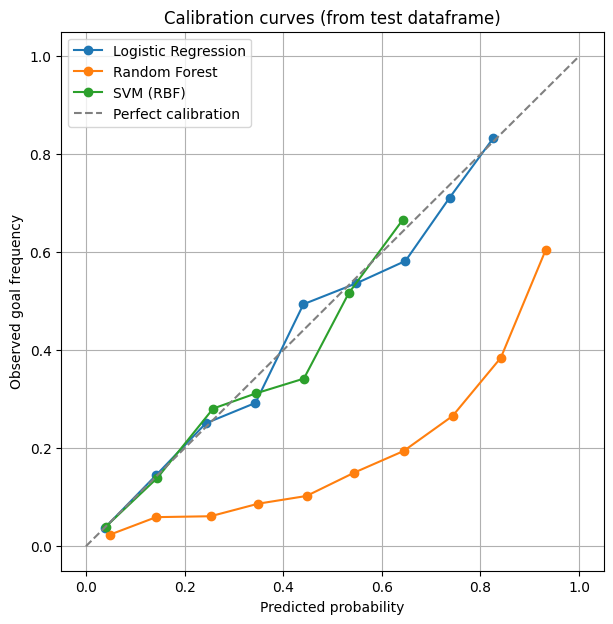

In [111]:
plt.figure(figsize=(7, 7))

plot_calibration_from_df(df_test, "prediction_lr", "Logistic Regression")
plot_calibration_from_df(df_test, "prediction_rf", "Random Forest")
plot_calibration_from_df(df_test, "prediction_svm", "SVM (RBF)")

# Perfect calibration
plt.plot([0, 1], [0, 1], "--", color="gray", label="Perfect calibration")

plt.xlabel("Predicted probability")
plt.ylabel("Observed goal frequency")
plt.title("Calibration curves (from test dataframe)")
plt.legend()
plt.grid(True)
plt.show()


## 8.2 Phân tích sai số theo không gian và ngữ cảnh

### 8.2.1 Phân tích sai số theo từng khoảng cách sút

In [112]:
df_test["dist_bucket"] = pd.cut(
    df_test["distToGoalLine"],
    bins=[0, 5, 10, 20, 40, 100]
)

df_test.groupby("dist_bucket")[[
    "overprediction_lr",
    "overprediction_rf",
    "overprediction_svm"
]].mean()


/tmp/ipykernel_50413/972867610.py:6: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



,overprediction_lr,overprediction_rf,overprediction_svm
dist_bucket,,,
"(0, 5]",0.036483,0.305346,-0.104961
"(5, 10]",-0.018513,0.294352,-0.008765
"(10, 20]",0.007058,0.248114,0.010692
"(20, 40]",-0.000081,0.082575,0.011906
"(40, 100]",0.000602,0.034084,0.024974


### 8.2.2 Phân tích sai số theo góc sút

In [113]:
df_test["angle_bucket"] = pd.cut(
    df_test["angle"],
    bins=[0, 20, 40, 60, 90]
)

df_test.groupby("angle_bucket")[[
    "overprediction_lr",
    "overprediction_rf",
    "overprediction_svm"
]].mean()


/tmp/ipykernel_50413/2773941439.py:6: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



,overprediction_lr,overprediction_rf,overprediction_svm
angle_bucket,,,
"(0, 20]",-0.008113,0.190851,0.005590
"(20, 40]",0.013690,0.193488,0.018372
"(40, 60]",-0.005495,0.158674,-0.008773
"(60, 90]",0.004029,0.103437,-0.000210


### 8.2.3 Sai số theo ngữ cảnh chiến thuật

#### Phản công

In [114]:
df_test.groupby("Counter attack")[[
    "overprediction_lr",
    "overprediction_rf",
    "overprediction_svm"
]].mean()


,overprediction_lr,overprediction_rf,overprediction_svm
Counter attack,,,
0,-0.000657,0.205283,-0.001249
1,0.025883,0.269524,0.036929


#### Phạt góc

In [115]:
df_test.groupby("corner")[[
    "overprediction_lr",
    "overprediction_rf",
    "overprediction_svm"
]].mean()


,overprediction_lr,overprediction_rf,overprediction_svm
corner,,,
0.0,0.000321,0.208143,0.000427
1.0,0.019829,0.233974,0.016788


#### Trước khung thành

In [116]:
df_test.groupby("frontOfGoal")[[
    "overprediction_lr",
    "overprediction_rf",
    "overprediction_svm"
]].mean()


,overprediction_lr,overprediction_rf,overprediction_svm
frontOfGoal,,,
0,-0.000515,0.205709,0.006696
1,0.060986,0.350672,-0.275292
